In [34]:
# 导入包
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize # word_tokenize函数

from collections import Counter # Counter类
from torch.autograd import Variable

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [90]:
# 初始化参数设置
UNK = 0  # 未登录词的标识符对应的词典id
PAD = 1  # padding占位符对应的词典id
BATCH_SIZE = 64  # 每批次训练数据数量
EPOCHS = 20  # 训练轮数
LAYERS = 6  # transformer中堆叠的encoder和decoder block层数
H_NUM = 8  # multihead attention hidden个数
D_MODEL = 256  # embedding维数
D_FF = 1024  # feed forward第一个全连接层维数
DROPOUT = 0.1  # dropout比例
MAX_LENGTH = 60  # 最大句子长度

In [91]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判断使用的是cpu还是gpu

In [92]:
# 路径设置
TRAIN_FILE = 'Dataset/train.txt'  # 训练集数据文件
DEV_FILE = "Dataset/dev.txt"  # 验证(开发)集数据文件
SAVE_FILE = 'Dataset/model.pt'  # 模型保存路径(注意如当前目录无save文件夹需要自己创建)

In [93]:
# 实现填充：
def seq_padding(X, padding=0):
    """
    X是长这样的，是一个batch_size的英文或中文句子索引
    batch_en=[en[0],en[1],...,en[batch_size-1]]或batch_cn=[cn[0],cn[1],...,cn[batch_size-1]]
        其中en和cn是长这样的，不过里面的单词都被替换成了数字索引
        [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]
    """

    L = [len(x) for x in X]
    
    ML = max(L)
    
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ]) # 以最长的句子为基准，等长的不变，即x；短于其的，补0，即np.concatenate([x, [padding] * (ML - len(x))])

# 实现掩码：
def subsequent_mask(size):
    '''
    后续掩码
        size是列维度
    '''
    
    attn_shape = (1, size, size)
    
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # 一个三角矩阵，主对角线（左上到右下）以下全为0，包括主对角线
    
    return torch.from_numpy(subsequent_mask) == 0 # 一个三角矩阵，主对角线以下全为True，包括主对角线

# 掩码
class Batch:
    def __init__(self, src, trg=None, pad=0):
        '''
        src和trg都是：一个batch_size的英语和中文句子（索引的形式），等长的，都用padding补齐
        src.shape=batch_size x ML
        trg.shape=batch_size x ML，这两个ML可能是不同的，具体见seq_padding部分
        '''
        src = torch.from_numpy(src).to(DEVICE).long() # 将numpy数组src转换成pytorch张量，并移动到指定设备，最后将数据类型转换成长整型long
        trg = torch.from_numpy(trg).to(DEVICE).long() # 将numpy数组src转换成pytorch张量，并移动到指定设备，最后将数据类型转换成长整型long
        self.src = src
        
        
        self.src_mask = (src != pad).unsqueeze(-2) # src_mask用于在处理数据时，忽略padding部分；非padding部分为True，padding部分为False
        # src_mask.shape=batch_size x 1 x ML

#---------------------------------------------------------以上是对英文数据集的操作--------------------------------------------------------------#


        
#---------------------------------------------------------以下是对中文数据集的操作--------------------------------------------------------------#
        
        # 如果输出目标不为空，则需要对decoder要使用到的target句子进行mask
        if trg is not None:
            self.trg = trg[:, :-1] # 砍去最后一列

            self.trg_y = trg[:, 1:] # 砍去第一列
            
            self.trg_mask = self.make_std_mask(self.trg, pad)
            
            # 将应输出的target结果中实际的词数进行统计
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # Mask掩码操作
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2) # 忽视padding填充的操作，得到batch_size x 1 x (ML-1)
        
        # tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)) # 舍弃Variable类
        tgt_mask = tgt_mask & (subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)) # batch_size x 1 x (ML-1) & 1 x (ML-1) x (ML-1)，由broadcasting机制，得到：batch_size x (ML-1) x (ML-1)
        '''
        &操作：指明要结合padding掩码和后续掩码(subsequnet_mask)

        subsequent_mask后续掩码，得到 1 x (ML-1) x (ML-1) 
        .type_as将后续掩码得到的结果转换成与tgt_mask一样的数据类型
        '''
        
        return tgt_mask

# 数据预处理：
class PrepareData:
    def __init__(self, train_file, dev_file):

        # 读取数据 并分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)

        # 构建单词表：只用训练集
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # id化，并且升序排列
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # 划分batch + padding + mask，splitBatch函数、seq_padding函数、Batch类构造函数
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        返回的值en和cn形式如下：
        en = [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]
                
        cn = [
                ['BOS', '我', '爱', '你', 'EOS'],
                ['BOS', '我', '也', '是', 'EOS'],
                ...]
        """
       
        en = []
        cn = []

        
        with open(path, 'r', encoding='utf-8') as fin:
            for line in fin:
                list_content = line.split('\t')
                en.append(['BOS'] + word_tokenize(list_content[0]) + ['EOS'])
                cn.append(['BOS'] + word_tokenize(" ".join(list_content[1])) + ['EOS'])

        return en, cn
    
    def build_dict(self, sentences, max_words = 50000):
        """
        sentences长这样
        [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]

        word_list是字典：key值是单词，value值是索引
        total_words是字典长度
        index_dict是字典：key值是索引，value值是单词
        """
        word_count = Counter() # 是一个字典对象，用来记录出现的单词的次数

        # sentences是多行句子
        # sentence是一行句子
        # s是一行句子中的一个单词
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
        
        
        ls = word_count.most_common(max_words) # 只保留最高频的前max_words数的单词构建词典，这个是一个字典（key值是单词、符号；而value值是频数）

        total_words = len(ls) + 2 # 统计词典的总词数，之后要加上UNK和PAD两个单词，所以要长度加2

        # 创建字典：key值是单词的首字母，value值是索引

        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}

        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        

        
        # 创建字典：key值是索引，value值是单词
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        en是长这样的：
        [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]
        ch是长这样的：
        [
                ['BOS', '我', '爱', '你', 'EOS'],
                ['BOS', '我', '也', '是', 'EOS'],
                ...]
        en_dict是：字典，它的key值是单词，value值是索引
        cn_dict是：字典，它的key值是单词，value值是索引

        
        该方法可以将翻译前(英文)数据和翻译后(中文)数据的单词列表表示的数据
        均转为id列表表示的数据
        如果sort参数设置为True，则会以翻译前(英文)的句子(单词数)长度排序
        以便后续分batch做padding时，同批次各句子需要padding的长度相近减少padding量
        """
        # 计算英文数据条数
        length = len(en)
        
        # w是个单词，从字典中找这个值对应的索引，如果没有这个单词，就返回0，即代表UNK
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        def len_argsort(seq):
            """
            seq是长这样的，不过里面的单词都被替换成了数字索引
            [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]
            按照句子长度排序后，返回排序后原来各句子在数据中的索引下标
            """
            
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        if sort:
            sorted_index = len_argsort(out_en_ids) # sorted_index是一个索引列表，这个索引对应的是out_en_ids的行。体现out_en_ids每行从短到长排序。
            
            # 按照长短重新升序排列
            out_en_ids = [out_en_ids[i] for i in sorted_index]
            out_cn_ids = [out_cn_ids[i] for i in sorted_index]
            
        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        en和cn是长这样的，不过里面的单词都被替换成了数字索引
        [
                ['BOS', 'i', 'love', 'you', 'EOS'],
                ['BOS', 'me', 'too', 'EOS'],
                ...]
        """
        idx_list = np.arange(0, len(en), batch_size) # ldx=[0, batch_size, batch_size*2, ...]
        
        if shuffle:
            np.random.shuffle(idx_list)
        
        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en)))) 
            # 在未洗牌时，batch_indexs=[[0,1,...,batch_size-1],[batch_size,1,...,batch_size*2-1],...]
        
        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]
            # 取batch_indexs第一个元素时：batch_en=[en[0],en[1],...,en[batch_size-1]]
            
            batch_cn = [cn[index] for index in batch_index]
            # 取batch_indexs第一个元素时，batch_cn=[cn[0],cn[1],...,cn[batch_size-1]]

            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # batch_cn的每个元素都等长，同时batch_en的每个元素都等长，两者未必等长
            
            batches.append(Batch(batch_en, batch_cn))
            # batches是一个列表，每个元素都是一个Batch类实例，包含了一个batch_size的英语和中文句子（索引的形式）

        return batches

In [94]:
# 生成训练数据集：
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict) # 英文单词数
tgt_vocab = len(data.cn_word_dict) # 中文单词数
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

src_vocab 50002
tgt_vocab 5212


---

---

In [95]:
# 生成词向量：
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()

        self.lut = nn.Embedding(vocab, d_model)

        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

---

---
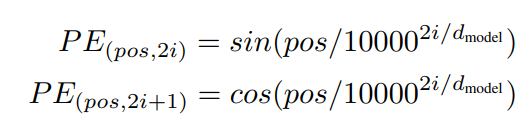

In [96]:
# 加入位置信息：
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        '''
        :max_len 解码器Decoder生成的句子中最多含有的词数目
        :d_model 用d_model维度的向量表示一个词
        '''
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model, device=DEVICE) # pe为[max_len, d_model]
        position = torch.arange(0, max_len, device=DEVICE).unsqueeze(1) # position为[max_len-1, 1]

        div_term = torch.exp((torch.arange(0, d_model, 2,  dtype=torch.float, device=DEVICE) *
                             -(math.log(10000.0)/d_model))) # 计算分母
        # torch.arange(0, d_model, 2,  dtype=torch.float, device=DEVICE)就是2i
        # -(math.log(10000.0)/d_model)就是-ln(10000.0)/d_model=ln(1/10000.0)/d_model
        # 原式=e^[2i * ln(1/10000.0) / d_model] = {e^[ln(1/10000.0)]}^(2i / d_model) = (1/10000.0)^(2i / d_model) = 1/[10000.0^(2i / d_model)]
        
        pe[:, 0::2] =  torch.sin(position.float() * div_term) # 即PE(pos, 2i)
        pe[:, 1::2] =  torch.cos(position.float() * div_term) # 即PE(pos, 2i+1)
        
        pe = pe.unsqueeze(0) # pe为[1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        :x [1, seq_len, d_model]，seq_len（就是一个句子中含有多少个词）往往小于max_len
        '''
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

---

---
得到注意力值：

$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [97]:
# 实现注意力机制：
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1) 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # 加入掩码mask操作：
    if mask is not None:
        mask.cuda()
        scores = scores.masked_fill(mask == 0, -1e9)
        
    p_attn = F.softmax(scores, dim = -1)

    # 加入dropout操作：
    if dropout is not None:
        p_attn = dropout(p_attn)
        
    return torch.matmul(p_attn, value), p_attn # 返回注意力值，概率

---

---
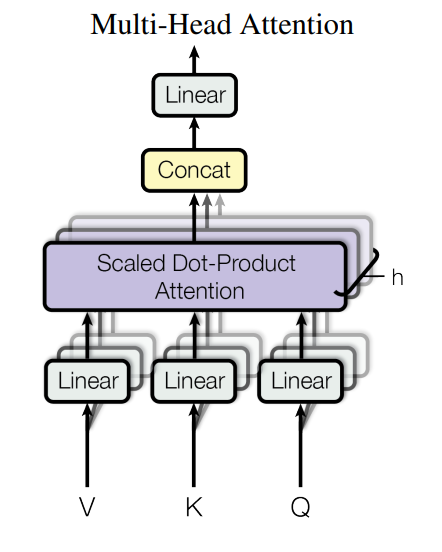

In [98]:
# 实现多头注意力机制：
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        '''
        :h 头数，论文中取得8
        :d_model 输入的维度，取256
        :dropout
        '''
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # 要确保输入的维度能被头数整除
        self.d_k = d_model // h # 投影维度
        self.h = h # 头数

        # 有四次投影，或者说四次线性变换
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        
        self.attn = None
        
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        '''
        :query [b, 每个样本最多有多少词, 用512维度向量表示一个词]
        :key
        :value
        :mask
        '''
        # 掩码mask操作：
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        nbatches = query.size(0) # 得到batch_size，因为多头后面要做切分

        query = self.linear_query(query).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        key = self.linear_key(key).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        value = self.linear_value(value).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        # 转变成：[b, self.h=8, 每个样本最多有多少词=the element number of query // batch_size, self.d_k=32]，self.h x self.d_k = 256

        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout) # 调用注意力机制函数，得到注意力值和注意力概率
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) # contiguous()实现的是拼接
        # 转变回：[b, 每个样本最多有多少词, self.h x self.d_k = 256]

        return self.linear_out(x)

---

---
Layer Normalization公式：

$y=\frac{x-E(x)}{\sqrt{Var(x)+\epsilon}} \times \gamma + \beta$，其中$\gamma$和$\beta$是学习参数

In [99]:
# 实现Layer Normalization操作：
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) # gamma
        self.b_2 = nn.Parameter(torch.zeros(features)) # beta
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        # 这里的mean和std都是按照每个样本来操作的，得到的结果是一个向量，它的维度是：batch_size x 1

        return  self.a_2 * ( x - mean) / torch.sqrt(std ** 2 + self.eps) + self.b_2 

---

---

That is, the output of each sub-layer is LayerNorm(x+Sublayer(x)) 对应：self.norm(x+sublayer(x))

We apply dropout to the output of each sub-layer 对应：self.dropout($\cdots$)

In [100]:
# 无论是Encoder还是Decoder的子层，都是用的这个类 
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) # Layer Normalization
        self.dropout = nn.Dropout(dropout) # Residual Dropout

    def forward(self, x, sublayer):
        return self.dropout(self.norm(x+sublayer(x))) # 串接子层

---

---
$FFN(x)=max(0, xW_1+b_1)W_2+b_2$

$b_1$和$b_2$可以略去

In [101]:
# 全连接层：
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

---

---

In [102]:
# 实现Decoder最后的Linear层和softmax层：
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

---

---

In [103]:
# 克隆子层：
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

---

---

In [104]:
# 构造一层Encoder：
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size


    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [105]:
# 构造完整的Encoder：
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

---

---

In [106]:
# 构造一层Decoder：
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        # self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [107]:
# 构造完整的Decoder：
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

---

---

In [108]:
# Transformer类：
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator 

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # return self.generator(self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask))
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [109]:
# 构造模型函数：
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy # 改名，深拷贝函数
    attn = MultiHeadedAttention(h, d_model).to(DEVICE) # 多注意力机制实例
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE) # 子层中的全连接层实例
    position = PositionalEncoding(d_model, dropout).to(DEVICE) # 位置信息实例
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    for p in model.parameters(): # 权重初始化——Xavier初始化
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

In [110]:
# 创建一个Transformer模型：
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

---

---
提高了困惑度，模型变得更加不确定，提高了准确性和$BLEU$分数

In [111]:
# 对标签进行平滑处理：
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') # KLdivloss（KL散度损失）
        self.padding_idx = padding_idx
        self.smoothing = smoothing
        self.size = size

    def forward(self, lprobs, target):
        true_dist = torch.full_like(lprobs, self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        true_dist[:, self.padding_idx] = 0
        return self.criterion(lprobs, true_dist)

---

---

$l_{rata}=factor \cdot d^{-0.5}_{model} \cdot min(step\_num^{-0.5}, \, step\_num \cdot warmup\_steps^{-1,5})$

In [112]:
# 自定义的学习率调节器类，有优化器和动态学习率调整的功能
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer # 优化器
        self._step = 0 
        self.warmup = warmup # 学习率预热步数
        self.factor = factor # 学习率的缩放因子
        self.model_size = model_size # 模型的维度
        self._rate = 0
        
    def step(self):
        self._step += 1 # 执行一次，_step加1
        rate = self.rate() # 得到当前的学习率
        for p in self.optimizer.param_groups: # 将当前的学习率用于优化器参数组
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step() # 参数更新
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

---

---

In [113]:
# 计算损失，计算模型输出与目标之间的损失，并执行反向传播和优化步骤
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator # 这是一个函数或是模型：将Transformer模型的输出转换为适合计算损失的格式
        self.criterion = criterion # 损失函数，如nn.CrossEntropyLoss
        self.opt = opt # 优化器
        
    def __call__(self, x, y, norm):
        '''
        :x Transformer的输出
        :y 真实标签
        :norm 用于归一化损失的值，通常是batch_size
        '''
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

---

---

In [114]:
# 在一个Epoch中的训练：主要用来记录损失
def run_epoch(data, model, loss_compute, epoch):
    '''
    :data 训练集
    :model Transformer模型
    :loss_compute 计算损失的函数
    :epoch 轮次
    '''
    start = time.time() # 记录当前时间，用于计算每个批次的处理时间
    total_tokens = 0. # 记录处理的总token数量
    total_loss = 0. # 记录总损失
    tokens = 0. # 记录当前批次的token数量

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask) # Transformer输出值
        loss = loss_compute(out, batch.trg_y, batch.ntokens) #计算损失，loss是SimpleLossCompute实例，callable

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1: # 打印消息
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens

In [115]:
# 训练函数：
def train(data, model, criterion, optimizer):
    '''
    :data 训练集+验证集
    :model Transformer模型
    :criterion 损失函数
    :optimizer 优化器
    '''
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        model.train() # 将模型设置为训练模式，启动dropout和batch normalization等训练特性
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval() # 将模式设置为评估模式，禁止dropout和batch normalization等训练特性
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss
        
        
        print()

---

---

In [116]:
# 训练：
print(">>>>>>> start train")
train_start = time.time() # 记录开始训练的时间
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0) # LabelSmoothing实例
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9)) # 优化器NoamOpt实例

train(data, model, criterion, optimizer) # 训练
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds") # 打印训练总时间

>>>>>>> start train
Epoch 0 Batch: 0 Loss: 8.606107 Tokens per Sec: 6.335171s
Epoch 0 Batch: 50 Loss: 8.210087 Tokens per Sec: 15.376044s


KeyboardInterrupt: 

---

---

In [117]:
# 贪婪解码(greedy decoding)算法，生成序列：
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

---

---

In [118]:
# 评估函数：
def evaluate(data, model):
    with torch.no_grad():
        for i in range(len(data.dev_en)):
            en_sent = " ".join([data.en_index_dict[w] for w in  data.dev_en[i]])
            print("\n" + en_sent)
            cn_sent = " ".join([data.cn_index_dict[w] for w in  data.dev_cn[i]])
            print("".join(cn_sent))
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            src = src.unsqueeze(0)
            src_mask = (src != 0).unsqueeze(-2)
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            translation = []
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            print("translation: %s" % " ".join(translation))

---

---

In [119]:
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))

<All keys matched successfully>

---

---

In [120]:
# 评估：
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)         
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS Hi . EOS
BOS 嗨 。 EOS
translation: 

BOS Hi . EOS
BOS 你 好 。 EOS
translation: 的 的 的 的

BOS Run . EOS
BOS 你 用 跑 的 。 EOS
translation: 我 的 的 的 的 的

BOS Stop ! EOS
BOS 住 手 ！ EOS
translation: 

BOS Wait ! EOS
BOS 等 等 ！ EOS
translation: 我

BOS Wait ! EOS
BOS 等 一 下 ！ EOS
translation: 我 的 的 的 的 的 的 的 的

BOS Begin . EOS
BOS 开 始 ！ EOS
translation: 我 的 的 的 的

BOS Hello ! EOS
BOS 你 好 。 EOS
translation: 我 的 的 的 的 的 的 的 的

BOS UNK ! EOS
BOS 乾 杯 ! EOS
translation: 

BOS Listen . EOS
BOS 听 着 。 EOS
translation: 我 的 的 的 的

BOS Really ? EOS
BOS 真 的 ？ EOS
translation: 

BOS Really ? EOS
BOS 你 确 定 ？ EOS


KeyboardInterrupt: 